In [2]:
%matplotlib inline

,category,Stim,OldNumber,Recognition_ACC,Recognition_RESP,Recognition_RT,Spatial_RESP,Spatial_RT,Spatial_ACC(,corriger
0,OLD,food_shellpasta.bmp,Old25,0,2,2413,0,NaN,NaN,NaN
1,OLD,sporting_boxing_gloves.bmp,Old56,1,1,1385,6,2208.0,NaN,NaN
2,OLD,sporting_footballhelmet.bmp,Old57,1,1,1277,5,1833.0,NaN,NaN
3,New,kitchen_ramekin.bmp,New13,1,2,3588,5,1833.0,NaN,NaN
4,OLD,sporting_bicycle_old.bmp,Old55,1,1,1708,9,1750.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
112,OLD,sporting_hockey,stick_old.bmp,Old58,1,1,2299,8.0,1886.0,NaN
113,New,animal_horse.bmp,New20,1,2,1561,8,1886.0,NaN,NaN
114,New,musical_french,horn_old.bmp,New12,1,2,944,8.0,1886.0,NaN
115,New,animal_gorilla.bmp,New15,0,1,2082,6,1590.0,NaN,NaN


In [320]:
from nilearn.glm.first_level import make_first_level_design_matrix as mfldm
from nilearn.glm.first_level import first_level_from_bids
from nilearn.plotting import plot_design_matrix as plot1dm

class participant():
    def __init__(self):
        self = self
        self.infos = loadinfos2().sample()
        self.t_r = nib.load(self.func).header.get_zooms()[-1]
        self.confounds = pd.read_csv(self.infos.confounds, sep='\t')
        self.n_frames = self.confounds.shape[0]
        self.frame_times = np.arange(self.n_frames) * self.t_r
        self.events = pd.read_csv(self.infos.events2,
                                  sep='\t').drop('Unnamed: 0', axis=1)
        self.ctl = pd.read_csv(self.infos.ctlonly,
                                  sep='\t').drop('Unnamed: 0', axis=1)
        self.anat = nib.load(self.infos.anat)
        self.func = nib.load(self.infos.func)
        self.mean_datas = df.from_dict(dict(itm[1] for itm in self.mean_datas[0].iteritems()), orient='index').transpose()
        self.behav = self.mean_datas.behav.dropna()
        self.bids =  self.mean_datas.bids.dropna()
        self.mean_motion = self.mean_datas.mean_motion.dropna()
        self.npsych = df(pd.Series(flatten(tuple(zip(self.mean_datas))))[3])
        self.matrix01 = self.matrix1()
        self.matrix02 = self.matrix2()
    def matrix1(self):
        return mfldm(frame_times=self.frame_times, events=self.events[self.events.Condition == 'Enc'],
                     hrf_model='spm', drift_model=None, high_pass=0.05,
                            add_regs=[self.confounds, self.mean_motion])
    def matrix2(self):
        return mfldm(frame_times=self.frame_times, events=self.ctl,
                     hrf_model='spm', drift_model=None, high_pass=0.05,
                            add_regs=[self.confounds, self.mean_motion])
# Create the model - Should data be standardized?
trial_model = FirstLevelModel(high_pass=0.05,
                              smoothing_fwhm=8.0,
                              memory_level=10,
                              standardize=True, 
                              noise_model='ar1',
                              verbose=3,
                              n_jobs=-2,
                              minimize_memory=True,
                              subject_label=subject, 
                              drift_model = None,
                              hrf_model = 'spm')
# Fit model with design matrix
p1, subject, datas, memsheet, motsheet, ctlsheet,
anat, anatjson, func, funcjson = loadsubject()
trial_model = trial_model.fit(
    run_imgs=func, design_matrices=encMatrix.values.flatten())

# X1=subject.matrix01
# X2=subject.matrix02
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 6), nrows=1, ncols=3)
# plot_design_matrix(X1, ax=ax1)
# ax1.set_title('Event-related design matrix', fontsize=12)
# plot_design_matrix(X2, ax=ax2)
# ax2.set_title('Block design matrix', fontsize=12)
# plot_design_matrix(X3, ax=ax3)
# ax3.set_title('FIR design matrix', fontsize=12)
# plt.subplots_adjust(left=0.08, top=0.9, bottom=0.21, right=0.96, wspace=0.3)
# plt.show()

encMatrix = mk1dm(frame_times = np.arange(sub02.confounds.shape[0])*sub02.RepetitionTime,
                  events=sub02.events, add_regs=sub02.confounds,
                  hrf_model='spm', high_pass=0.05)
display(encMatrix)


### Trial-unique beta maps processing steps - CIMAQ fMRI data 
    - Outputed beta maps
        - Meant to be fed as features to a within-subject nilearn classifier.
#### Input:
    - task (event) files generated from raw eprime (.txt) outputs and organized into .tsv file 
      by cimaq_convert_eprime_to_bids_event.py script
    - confound (motion, etc) files generated from Niak preprocessing
      pipeline (confounds.tsv) 
    - preprocessed Niak data (4D .nii file found under resample

##### Note: data are not smoothed)
- Output
    - 1 beta (regression) weights map (3D .nii file) of for each trial
    - Concatenated 4D file of these 3D maps (trials ordered chronologically).

##### Note: comparing 2 different ways to model trials of no interest
#### Version 1: Separate model built for each trial
    - Trial of interest modelled as a separate condition (1 regressor)
    - All the other trials modelled in either Encoding or Control condition (2 regressors)
    
**Update: betas from version 1 lead to much better enc/ctl trial classification**
#### Version 2: Separate model built for each trial
    - trial of interest modelled as a separate condition (1 regressor)
    - All the other trials modelled as a single "other" condition (1 regressor)
    
**Update: betas from version2 lead to poorer enc/ctl trial classification**

Reference: how to derive beta maps for MVPA classification (Mumford et al., 2012):
https://www.sciencedirect.com/science/article/pii/S1053811911010081

Also creating contrasts per condition (to derive features for between-subject classification): 
- A) enconding and control conditions across trials 
- 3 beta maps
    - encoding (enc)
    - control (ctl)
    - encoding minus control (enc_minus_ctl)
- B) Control &encoding conditions according to task performance
    - miss and hit (post-scan image recognition performance)
(5 beta maps: miss (miss), hit (hit), hit minus miss (hit_minus_miss), hit minus control
(hit_minus_ctl), miss minus control (miss_minus_ctl)
- C) control & encoding conditions according to task performance:
    - miss, wrong source, and correct source.

##### 7 beta maps
1. wrong source (wrong_source)
2. correct source (corr_source)
3. correct source minus wrong source (cs_minus_ws)
4. correct source minus miss (cs_minus_miss)
5. wrong source minus miss (ws_minus_miss)
6. correct source minus control (cs_minus_ctl)
7. wrong source minus control (ws_minus_ctl)

### Step 0: Index, Count and Sort Available Data
    #### -Several sheets per participant
        - Events ('events')
        - Behavioural Data ('retrieval')
        - Motion Parameters ('motion')

## Step 1: Load confound parameters from the confounds/resample directory
#### Outputed by NIAK preprocessing pipeline:
- slow signal drift
- motion parameters
- mean white matter
- mean ventricle signal intensity

**NB: The full NIAK preprocessing pipeline scrubs (regresses out) motion outlier frames, 
      possibly incompatible with Nilearn

### Use slice-timed, co-registered & resampled (motion-corrected) intermediate data
    - See **confounds_resample** directory (not under fMRI)
    - .nii format, with accompanying _extra.mat and confounds.tsv.gz files.
    
#### NB: These data have undergone 
- **no smoothing** 
- **confounds HAVEN'T been regressed out. 

Use gunzip *gz command to unzip .tsv files inside working directory

**Update: Nilearn to Nistats
Nilearn's First-level model**
- Can model **some of the slow drift & noise parameters** (not used here) 
- For each participant, the confounds used as regressors are the
  **counfounds.tsv sheets (including slow drift) 
- Therefore, slow drift etc are not modeled in the first-level model (redundant)

### Questions
 - To what correspond SOME of the said slow drift & noise parameters?

### Step 2: create events variable, and events.tsv file from the 'sub-*_ses-4_task-memory_events.tsv' task file outputed by the cimaq_convert_eprime_to_bids_event.py script 

#### Number of rows = number of trials
    - First-level model uses onset times to match conditions (trials) with fMRI frames).

Documentation:
https://nistats.github.io/auto_examples/04_low_level_functions/write_events_file.html#sphx-glr-auto-examples-04-low-level-functions-write-events-file-py

#### Each encoding trial...
##### is modelled as a different condition (under CONDITION column)
    - so that it is modelled separately when creating the design matrix.
##### has its own column in the design matrix
    - other columns = other trials (modelled together as single regressor), and confound regressors.

#### N.B.: Some scans were cut short: 
- the last few trials do not have associated brain activation frames
- "UNSCANNED" trials need to be excluded from model (about ~2-4 trials missing).
        - 310 frames = full scan
        - 288 frames = incomplete (~15 participants).

288*2.5 = 720s. 
Trial #115 (out of 117) offset time ~ 710s
Trial #116 (out of 117) onset ~ 723s

#### Exclude incomplete scans (i.e. 288 frames instead of 310)?

### Step3 : Implement first-level model, generate contrasts and output maps of beta values (parameter estimators; one map of betas per trial).

**About first-level model:

          
- Each encoding trial is modelled as a separate condition to obtain
  separate maps of beta values (model's output type to get betas
  - **effect sizes** (Nistats name), aka parameter estimates)
  
    - Trial of interest is modelled as a unique condition (column in the design matrix)
    - Other trials are modelled together.

- Version A: beside trial of interest (1 regressor)
    - control & encoding trials are modelled separately (2 regressors)
- Version B: beside the trial of interest (1 regressor),
    - Control & encoding trials are modelled together 
      as a single "other_trials" condition (1 regressor)

- Note 3: first_level_model can either be given
    - A) pre-constructed **design matrix** (priorly built from events & confounds files as a parameter
    - B) the **events and confounds** files directly as parameters (skipping design matrix creation step)
        - The model will generate and output the design matrix
        - As a parameter to the first-level-model:
            - Design matrix takes precedence over events & confounds parameters.

#### Design matrices:
    - https://nistats.github.io/auto_examples/04_low_level_functions/plot_design_matrix.html

    - https://nistats.github.io/modules/generated/nistats.design_matrix.make_first_level_design_matrix.html

Example of B) - not done here: https://nistats.github.io/auto_examples/01_tutorials/plot_first_level_model_details.html#running-a-basic-model

CHOSEN: 2-step method A)
**About contrasts & b-value maps (parameter estimators):

- Create design matrix directly from events & confounds
    - Files outputed from NIAK (resample directory)
- Generate & fit first-level-model
    - Each trial is modeled as a separate condition
        - Represented as its own design matrix column 

- To access the estimated coefficients (betas of the GLM model):
    - we need to specify "canonical contrasts" (one per trial) isolating design matrix columns
        - Each contrast has a single 1 in its corresponding colum, and 0s for all the other columns).

Sources of info: how to extract beta maps in nistats (instructions are a bit obscure)
https://15-35545854-gh.circle-artifacts.com/0/home/ubuntu/nistats/doc/_build/html/auto_examples/plot_spm_auditory.html
https://github.com/poldracklab/fitlins/pull/48
https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html#nistats.first_level_model.FirstLevelModel


### Version A - Separate model created for each trial
##### Trial of interest modelled as its own condition
##### Other trials are modelled as two conditions:
- Control, and Encoding (excluding trial of interest)

### Version A - encoding vs control conditions

##### Desing Matrix Creation - potentially obsolete


In [325]:
# # Create the model - Should data be standardized?
# cimaq = loadinfos2()
# subject = cimaq.sample()
# nilearn.glm.first_level.make_first_level_design_matrix(frame_times, events=None, hrf_model='glover', drift_model='cosine', high_pass=0.01, drift_order=1, fir_delays=[0], add_regs=None, add_reg_names=None, min_onset=-24, oversampling=50)¶


# trial_model = FirstLevelModel(high_pass=0.05,
#                               smoothing_fwhm=8.0,
#                               memory_level=10,
#                               standardize=True, 
#                               noise_model='ar1',
#                               verbose=3,
#                               n_jobs=-2,
#                               minimize_memory=True,
#                               subject_label=subject, 
#                               drift_model = None,
#                               hrf_model = 'spm')

# # Fit model with design matrix
# p1, subject, datas, memsheet, motsheet, ctlsheet, anat, anatjson, func, funcjson = loadsubject()

# trial_model = trial_model.fit(run_imgs=func,
#                                         design_matrices=encMatrix.values.flatten())
#         #create the model - Should data be standardized?
#         trial_model = FirstLevelModel(high_pass=0.05,
#                                       smoothing_fwhm=8.0,
#                                       memory_level=5,
#                                       standardize=True,
#                                       noise_model='ar1',
#                                       verbose=3,
#                                       n_jobs=-2,
#                                       minimize_memory=True,
#                                       subject_label=subject,
#                                       t_r=tr,
#                                       drift_model = None,
#                                       noise_model='ar1',
#                                       hrf_model = 'spm')
#         #fit model with design matrix
#         trial_model = trial_model.fit(fmri_img, design_matrices = design)

#         ##create the design matrix
# #         design = make_first_level_design_matrix(frame_times, events=events,
# #                                                 drift_model=None, add_regs=confounds, 
# #                                                 hrf_model=hrf_model)
#         design_matrix = trial_model.design_matrices_[0]
# #        sanity check: print design matrices and corresponding parameter labels
# #        plot outputed design matrix for visualization
#         #Contrast vector: 1 in design matrix column that corresponds to trial of interest, 0s elsewhere
#         contrast_vec = np.repeat(0, design_matrix.shape[1])
#         contrast_vec[0] = 1
#         #compute the contrast's beta maps with the model.compute_contrast() method,
#         #based on contrast provided. 
#         #https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html
#         b_map = trial_model.compute_contrast(contrast_vec, output_type='effect_size') #"effect_size" for betas
#         b_name = os.path.join(outBeta_dir_A, 'betas_sub'+str(id)+'_Trial'+str(tnum)+'_'+tname+'.nii')
#         #export b_map .nii image in output directory
#         nibabel.save(b_map, b_name)
#         print(os.path.basename(b_name))
#         all_betas_filelist_A.append(b_name)
#     alltrials_betas_A = nibabel.funcs.concat_images(images=all_betas_filelist_A, check_affines=True, axis=None)
#     print(alltrials_betas_A.shape)
#     nibabel.save(alltrials_betas_A, os.path.join(outBeta_dir_A, 'concat_all_betas_sub'+str(id)+'.nii'))
# # test = getbetasV2()
# # display(test)
# # display(design_matrices)

# outBeta_dir_A =xpu('~/getbmaps01')
# all_betas_filelist_B = []
# ####

# #Create a design matrix, first level model and beta map for each encoding and control trial 
# for i in range (0, numTrials):
#     #copy all_events dataframe to keep the original intact
#     events = all_events.copy(deep = True)
#     #Determine trial number and condition (encoding or control)
#     tnum = events.iloc[i, 6]
#     currentCondi = events.iloc[i, 3]
#     tname = events.iloc[i, 2]
#     #Version A: (2 conditions modelled separately)
#     #modify trial_type column to model only the trial of interest 
#     events2 = events.loc[row[0] for row in events2.iterrows()
#                          if row[0] != tnum]
#             #X for condition to remain in alphabetical order: trial of interest, X_CTL, X_Enc
#     #verify: what determines the order of columns in design matrix?    
#     #remove unecessary columns    
# #     events2 = events.loc[[row[0] for row in events.iterrows()
# #                              if row[0] != tnum]]
#     events2 =  [events.loc[events.isnull().any(axis=1), :] = np.nan
#          for row in events.iterrows() if row[0] != tnum]
    

#     events2 = events2.rename(columns={"stimOnsetSec": "onset",
#                                         "isiSec": "duration",
#                                         "tNumXcond": "trial_type"}).set_index(["Unnamed: 0"])
#     #create the model
#     s_model = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
#                                hrf_model = hrf_model)    
#     #Should data be standardized?
#     #create the design matrices
#     design = make_first_level_design_matrix(frame_times, events=events,
#                                             drift_model=None, add_regs=confounds, 
#                                             hrf_model=hrf_model)
#     #fit model with design matrix
#     s_model = s_model.fit(fmri_img, design_matrices = design)
#     design_matrix = s_model.design_matrices_[0]
#     #sanity check: print design matrices and corresponding parameter labels
#     #plot outputed design matrix for visualization
#     print(str(tnum), ' ', tname, ' ', design_matrix.columns[0:3])
#     plot_design_matrix(design_matrix)
#     plt.show()
#     #Contrast vector: 1 in design matrix column that corresponds to trial of interest, 0s elsewhere
#     contrast_vec = np.repeat(0, design_matrix.shape[1])
#     contrast_vec[0] = 1
#     #compute the contrast's beta maps with the model.compute_contrast() method,
#     #based on contrast provided. 
#     #https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html
#     b_map = s_model.compute_contrast(contrast_vec, output_type='effect_size') #"effect_size" for betas
#     b_name = os.path.join(outBeta_dir_B, 'betas_sub'+str(id)+'_Trial'+str(tnum)+'_'+tname+'.nii')
#     #export b_map .nii image in output directory
#     nibabel.save(b_map, b_name)
#     print(os.path.basename(b_name))
#     all_betas_filelist_B.append(b_name)
# alltrials_betas_B = nibabel.funcs.concat_images(images=all_betas_filelist_B, check_affines=True, axis=None)
# print(alltrials_betas_B.shape)
# nibabel.save(alltrials_betas_B, os.path.join(outBeta_dir_B, 'concat_all_betas_sub'+str(id)+'.nii'))
# outBeta_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts'
# events1 = all_events.copy(deep = True)
# cols = ['onset', 'duration', 'condition']
# events1 = events1[cols]
# events1.rename(columns={'condition':'trial_type'}, inplace=True)
# print(events1.head())
# #create the model
# model1 = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
#                          hrf_model = hrf_model)    
# #Should data be standardized?
# #create the design matrices
# design1 = make_first_level_design_matrix(frame_times, events=events1,
#                                         drift_model=None, add_regs=confounds, 
#                                         hrf_model=hrf_model)
# #fit model with design matrix
# model1 = model1.fit(fmri_img, design_matrices = design1)    
# design_matrix1 = model1.design_matrices_[0]    
# plot_design_matrix(design_matrix1)
# plt.show()
# print(design_matrix1.columns[0:5])
# #Condition order: control, encoding (alphabetical)
# #contrast 1.1: control condition
# ctl_vec = np.repeat(0, design_matrix1.shape[1])
# ctl_vec[0] = 1
# b11_map = model1.compute_contrast(ctl_vec, output_type='effect_size') #"effect_size" for betas
# b11_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ctl.nii')
# nibabel.save(b11_map, b11_name)
# print(os.path.basename(b11_name))
# print(ctl_vec)
# #contrast 1.2: encoding condition
# enc_vec = np.repeat(0, design_matrix1.shape[1])
# enc_vec[1] = 1
# b12_map = model1.compute_contrast(enc_vec, output_type='effect_size') #"effect_size" for betas
# b12_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_enc.nii')
# nibabel.save(b12_map, b12_name)
# print(os.path.basename(b12_name))
# print(enc_vec)
# #contrast 1.3: encoding minus control 
# encMinCtl_vec = np.repeat(0, design_matrix1.shape[1])
# encMinCtl_vec[1] = 1
# encMinCtl_vec[0] = -1
# b13_map = model1.compute_contrast(encMinCtl_vec, output_type='effect_size') #"effect_size" for betas
# b13_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_enc_minus_ctl.nii')
# nibabel.save(b13_map, b13_name)
# print(os.path.basename(b13_name))
# print(encMinCtl_vec)


### Model B: missed vs hit encoding trials
- Separate model created for each trial.
- Trial of interest modelled as its own condition
- Other trials are modelled as a single condition
    - (encoding and control, excluding trial of interest)

In [323]:
# events2 = all_events.copy(deep = True)
# cols2 = ['onset', 'duration', 'ctl_miss_hit']
# events2 = events2[cols2]
# events2.rename(columns={'ctl_miss_hit':'trial_type'}, inplace=True)

# print(events2.iloc[0:15, :])

# #create the model
# model2 = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
#                          hrf_model = hrf_model)    
# #Should data be standardized?
# #create the design matrices
# design2 = make_first_level_design_matrix(frame_times, events=events2,
#                                         drift_model=None, add_regs=confounds, 
#                                         hrf_model=hrf_model)

# #fit model with design matrix
# model2 = model2.fit(fmri_img, design_matrices = design2)    

# design_matrix2 = model2.design_matrices_[0]    
# plot_design_matrix(design_matrix2)
# plt.show()
# print(design_matrix2.columns[0:5])
# ##Condition order: control, hit, missed (alphabetical)
# #contrast 2.1: miss 
# miss_vec = np.repeat(0, design_matrix2.shape[1])
# miss_vec[2] = 1
# b21_map = model2.compute_contrast(miss_vec, output_type='effect_size') #"effect_size" for betas
# b21_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_miss.nii')
# nibabel.save(b21_map, b21_name)
# print(os.path.basename(b21_name))
# print(miss_vec)
# #contrast 2.2: hit 
# hit_vec = np.repeat(0, design_matrix2.shape[1])
# hit_vec[1] = 1
# b22_map = model2.compute_contrast(hit_vec, output_type='effect_size') #"effect_size" for betas
# b22_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_hit.nii')
# nibabel.save(b22_map, b22_name)
# print(os.path.basename(b22_name))
# print(hit_vec)
# #contrast 2.3: hit minus miss
# hit_min_miss_vec = np.repeat(0, design_matrix2.shape[1])
# hit_min_miss_vec[1] = 1
# hit_min_miss_vec[2] = -1
# b23_map = model2.compute_contrast(hit_min_miss_vec, output_type='effect_size') #"effect_size" for betas
# b23_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_hit_minus_miss.nii')
# nibabel.save(b23_map, b23_name)
# print(os.path.basename(b23_name))
# print(hit_min_miss_vec)
# #contrast 2.4: hit minus control
# hit_min_ctl_vec = np.repeat(0, design_matrix2.shape[1])
# hit_min_ctl_vec[1] = 1
# hit_min_ctl_vec[0] = -1
# b24_map = model2.compute_contrast(hit_min_ctl_vec, output_type='effect_size') #"effect_size" for betas
# b24_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_hit_minus_ctl.nii')
# nibabel.save(b24_map, b24_name)
# print(os.path.basename(b24_name))
# print(hit_min_ctl_vec)
# #contrast 2.5: miss minus control 
# miss_min_ctl_vec = np.repeat(0, design_matrix2.shape[1])
# miss_min_ctl_vec[2] = 1
# miss_min_ctl_vec[0] = -1
# b25_map = model2.compute_contrast(miss_min_ctl_vec, output_type='effect_size') #"effect_size" for betas
# b25_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_miss_minus_ctl.nii')
# nibabel.save(b25_map, b25_name)
# print(os.path.basename(b25_name))
# print(miss_min_ctl_vec)


### Model 3: correct source vs wrong source encoding trials

In [324]:
# events3 = all_events.copy(deep = True)
# cols3 = ['onset', 'duration', 'ctl_miss_ws_cs']
# events3 = events3[cols3]
# events3.rename(columns={'ctl_miss_ws_cs':'trial_type'}, inplace=True)

# print(events3.iloc[0:15, :])

# #create the model
# model3 = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
#                          hrf_model = hrf_model)    
# #Should data be standardized?
# #create the design matrices
# design3 = make_first_level_design_matrix(frame_times, events=events3,
#                                         drift_model=None, add_regs=confounds, 
#                                         hrf_model=hrf_model)
# #fit model with design matrix
# model3 = model3.fit(fmri_img, design_matrices = design3)    
# design_matrix3 = model3.design_matrices_[0]    
# plot_design_matrix(design_matrix3)
# plt.show()
# print(design_matrix3.columns[0:5])
# ##Condition order: control, correct source, missed, wrong source (alphabetical)
# #contrast 3.1: wrong source 
# ws_vec = np.repeat(0, design_matrix3.shape[1])
# ws_vec[3] = 1
# b31_map = model3.compute_contrast(ws_vec, output_type='effect_size') #"effect_size" for betas
# b31_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ws.nii')
# nibabel.save(b31_map, b31_name)
# print(os.path.basename(b31_name))
# print(ws_vec)
# #contrast 3.2: correct source
# cs_vec = np.repeat(0, design_matrix3.shape[1])
# cs_vec[1] = 1
# b32_map = model3.compute_contrast(cs_vec, output_type='effect_size') #"effect_size" for betas
# b32_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs.nii')
# nibabel.save(b32_map, b32_name)
# print(os.path.basename(b32_name))
# print(cs_vec)
# #contrast 3.3: correct source minus wrong source
# cs_minus_ws_vec = np.repeat(0, design_matrix3.shape[1])
# cs_minus_ws_vec[1] = 1
# cs_minus_ws_vec[3] = -1
# b33_map = model3.compute_contrast(cs_minus_ws_vec, output_type='effect_size') #"effect_size" for betas
# b33_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs_minus_ws.nii')
# nibabel.save(b33_map, b33_name)
# print(os.path.basename(b33_name))
# print(cs_minus_ws_vec)
# #contrast 3.4: correct source minus miss
# cs_minus_miss_vec = np.repeat(0, design_matrix3.shape[1])
# cs_minus_miss_vec[1] = 1
# cs_minus_miss_vec[2] = -1
# b34_map = model3.compute_contrast(cs_minus_miss_vec, output_type='effect_size') #"effect_size" for betas
# b34_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs_minus_miss.nii')
# nibabel.save(b34_map, b34_name)
# print(os.path.basename(b34_name))
# print(cs_minus_miss_vec)
# #contrast 3.5: wrong source minus miss
# ws_minus_miss_vec = np.repeat(0, design_matrix3.shape[1])
# ws_minus_miss_vec[3] = 1
# ws_minus_miss_vec[2] = -1
# b35_map = model3.compute_contrast(ws_minus_miss_vec, output_type='effect_size') #"effect_size" for betas
# b35_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ws_minus_miss.nii')
# nibabel.save(b35_map, b35_name)
# print(os.path.basename(b35_name))
# print(ws_minus_miss_vec)
# #contrast 3.6: correct source minus control
# cs_minus_ctl_vec = np.repeat(0, design_matrix3.shape[1])
# cs_minus_ctl_vec[1] = 1
# cs_minus_ctl_vec[0] = -1
# b36_map = model3.compute_contrast(cs_minus_ctl_vec, output_type='effect_size') #"effect_size" for betas
# b36_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs_minus_ctl.nii')
# nibabel.save(b36_map, b36_name)
# print(os.path.basename(b36_name))
# print(cs_minus_ctl_vec)
# #contrast 3.7: wrong source minus control
# ws_minus_ctl_vec = np.repeat(0, design_matrix3.shape[1])
# ws_minus_ctl_vec[3] = 1
# ws_minus_ctl_vec[0] = -1
# b37_map = model3.compute_contrast(ws_minus_ctl_vec, output_type='effect_size') #"effect_size" for betas
# b37_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ws_minus_ctl.nii')
# nibabel.save(b37_map, b37_name)
# print(os.path.basename(b37_name))
# print(ws_minus_ctl_vec)


#### Visualize beta maps
- plotting brain images in nilearn:
- http://nilearn.github.io/plotting/index.html

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_ws_minus_miss.nii


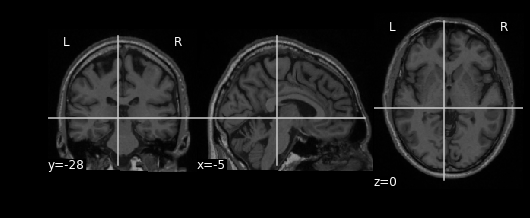

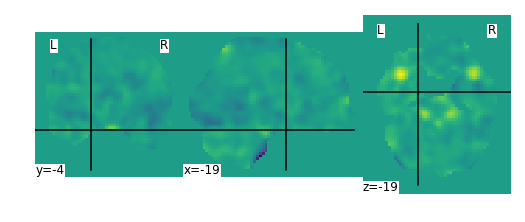

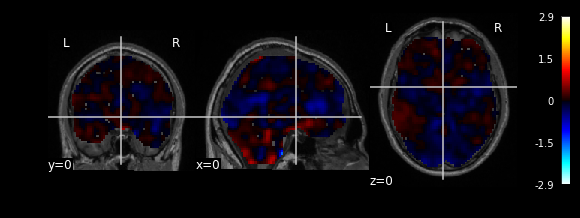

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_cs_minus_ws.nii


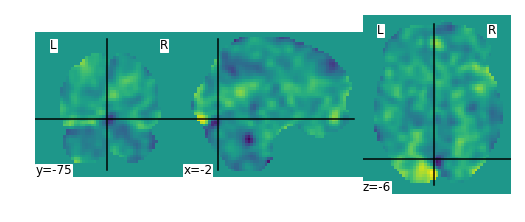

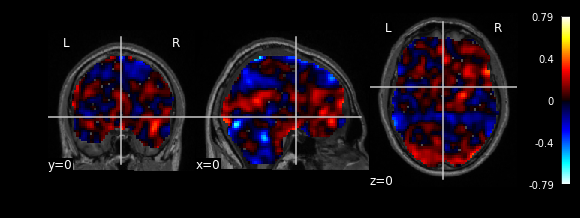

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_hit_minus_miss.nii


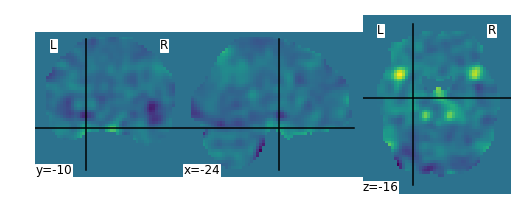

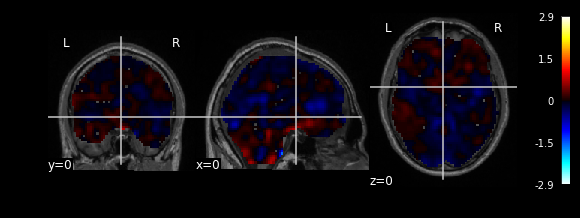

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_ws_minus_ctl.nii


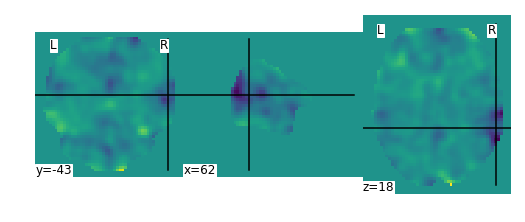

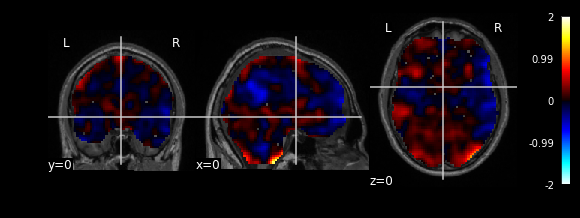

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_ctl.nii


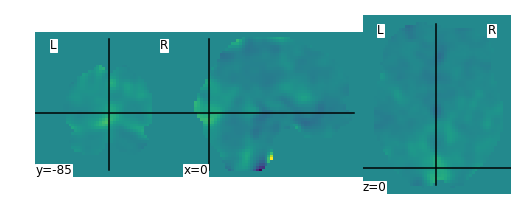

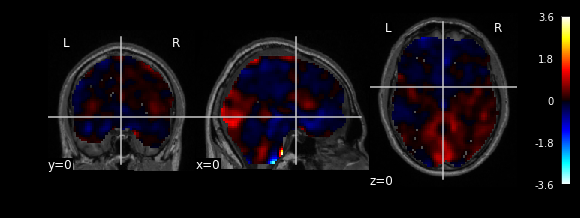

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_enc.nii


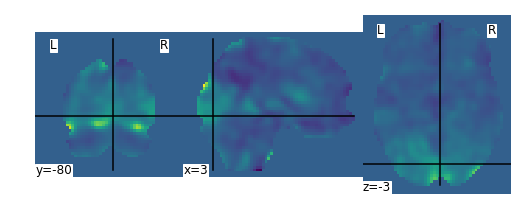

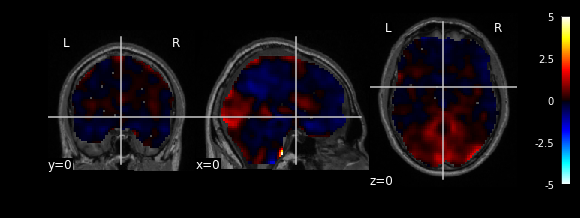

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_cs_minus_miss.nii


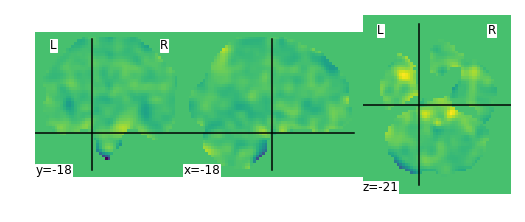

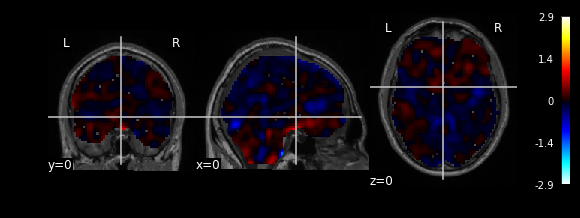

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_hit_minus_ctl.nii


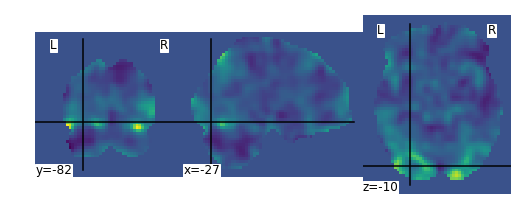

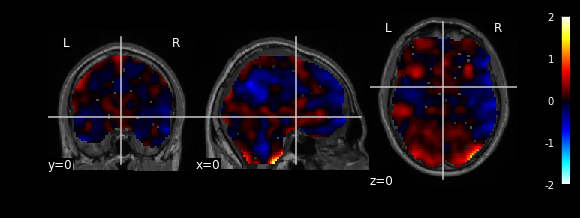

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_enc_minus_ctl.nii


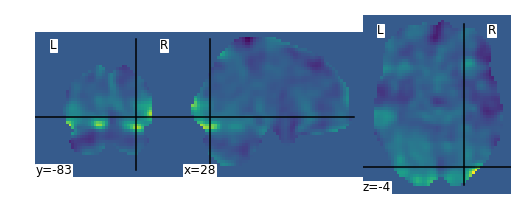

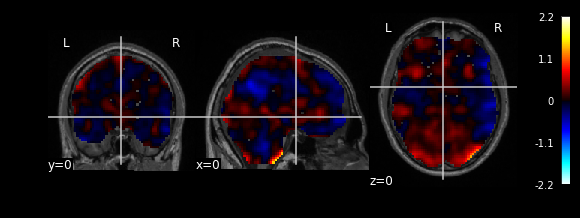

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_ws.nii


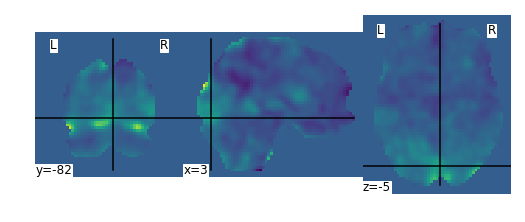

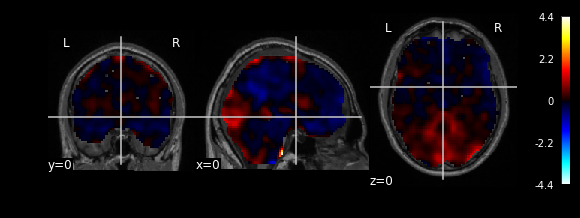

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_hit.nii


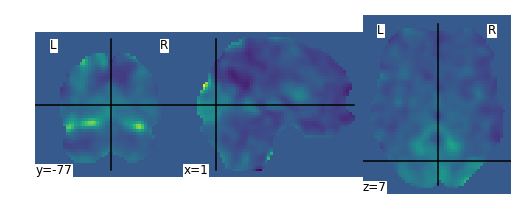

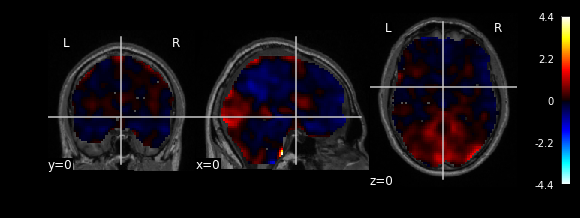

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_cs.nii


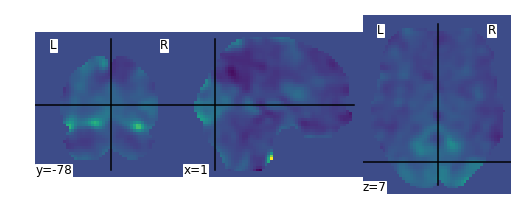

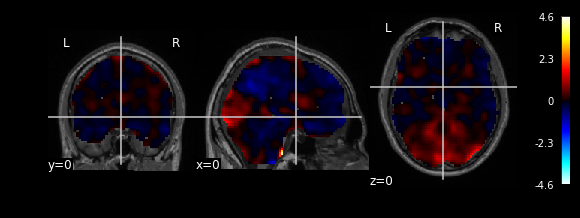

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_cs_minus_ctl.nii


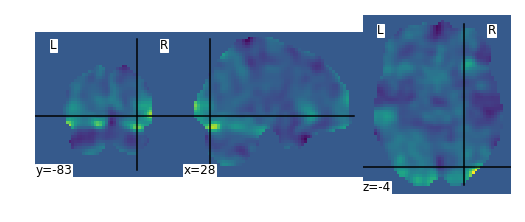

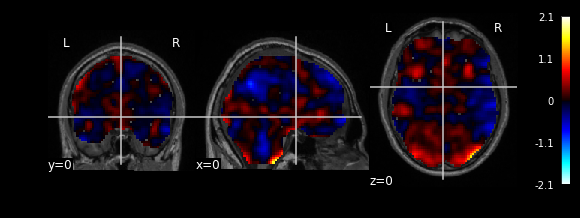

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_miss.nii


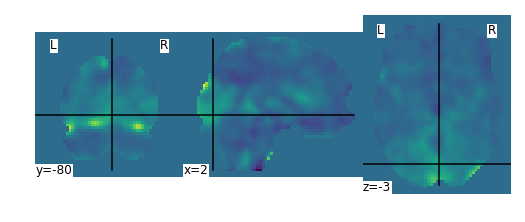

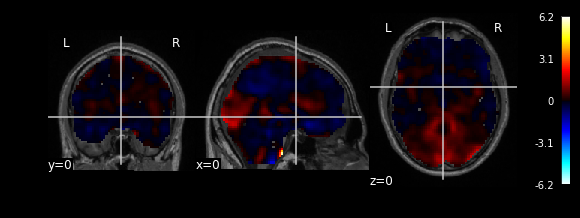

/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts/betas_sub122922_miss_minus_ctl.nii


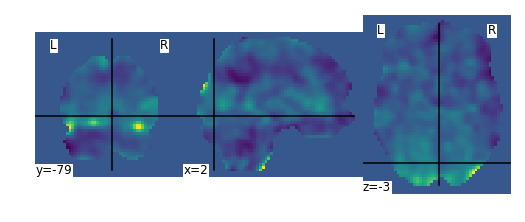

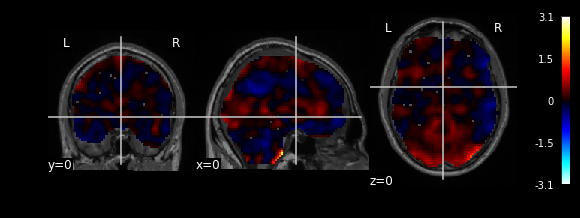

In [39]:
#define directory where subject's functional mask and anatomical scan reside
anat_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/anat/122922'
#subject's anatomical scan
anat = nibabel.load(os.path.join(anat_dir, 'anat_sub122922_nuc_stereonl.nii'))
plot_anat(anat)

beta_list = glob.glob(os.path.join(outBeta_dir, '*.nii'))

for beta in beta_list:
    print(beta)
    plot_img(beta)
    plot_stat_map(stat_map_img=beta, bg_img=anat, cut_coords=(0, 0, 0), threshold=0.001, colorbar=True)
    show()
##Not used in most current model##
#create "short" counfounds dataframe with only a subset of confounds
#these counfounds are to be used if slow drift, etc is modelled in nistats rather than niak
short_counfounds = confounds.copy(deep = True)

#select which columsn from NIAK counfounds.tsv file to include in first-level Nistats model 
#(when modelling slow-drift and other junk parameters within Nistats instead of NIAK)
colsKeep = ['motion_tx', 'motion_ty', 'motion_tz', 'motion_rx', 
            'motion_ry', 'motion_rz', 'scrub', 'wm_avg', 'vent_avg']
cols = confounds.columns

#remove columns not in list of colums to keep (colsKeep)
for i in cols:
    if (i in colsKeep)==False:
        short_counfounds.drop([i], axis=1, inplace=True)    
        